In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print('Importing data...')
data = pd.read_csv('application_train.csv')

Importing data...


In [3]:
target = data['TARGET']
del data['TARGET']

In [4]:
categorical_features = [col for col in data.columns if data[col].dtype == 'object']

In [5]:
categorical_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [6]:
data.head(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data = pd.get_dummies(data, columns=categorical_features)

In [8]:
data.head(2)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0,1,0,0,0,0,0,0,1,0


In [9]:
del data['SK_ID_CURR']

In [10]:
docs = [f for f in data.columns if 'FLAG_DOC' in f]
# Flag_document features - count and kurtosis
data['DOCUMENT_COUNT'] = data[docs].sum(axis=1)
data['NEW_DOC_KURT'] = data[docs].kurtosis(axis=1)

In [11]:
def get_age_label(days_birth):
    """ Return the age group label (int). """
    age_years = -days_birth / 365
    if age_years < 27: return 1
    elif age_years < 40: return 2
    elif age_years < 50: return 3
    elif age_years < 65: return 4
    elif age_years < 99: return 5
    else: return 0

In [12]:
# Categorical age - based on target=1 plot
data['AGE_RANGE'] = data['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

In [13]:
# New features based on External sources
data['EXT_SOURCES_PROD'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3']
data['EXT_SOURCES_WEIGHTED'] = data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 1 + data.EXT_SOURCE_3 * 3
np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
        data[feature_name] = eval('np.{}'.format(function_name))(
            data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [14]:
# Credit ratios
data['CREDIT_TO_ANNUITY_RATIO'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['CREDIT_TO_GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']

In [15]:
# Income ratios
data['ANNUITY_TO_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TO_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['INCOME_TO_EMPLOYED_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_EMPLOYED']
data['INCOME_TO_BIRTH_RATIO'] = data['AMT_INCOME_TOTAL'] / data['DAYS_BIRTH']

In [16]:
# Time ratios
data['EMPLOYED_TO_BIRTH_RATIO'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['ID_TO_BIRTH_RATIO'] = data['DAYS_ID_PUBLISH'] / data['DAYS_BIRTH']
data['CAR_TO_BIRTH_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
data['CAR_TO_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
data['PHONE_TO_BIRTH_RATIO'] = data['DAYS_LAST_PHONE_CHANGE'] / data['DAYS_BIRTH']

In [17]:
train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.2, shuffle=True)

In [18]:
#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

In [19]:
#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }

In [20]:
#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 40,
                 verbose_eval= 10
                 )

Training until validation scores don't improve for 40 rounds.
[10]	valid_0's auc: 0.743483
[20]	valid_0's auc: 0.747161
[30]	valid_0's auc: 0.751901
[40]	valid_0's auc: 0.75527
[50]	valid_0's auc: 0.758
[60]	valid_0's auc: 0.760326
[70]	valid_0's auc: 0.762249
[80]	valid_0's auc: 0.763844
[90]	valid_0's auc: 0.764923
[100]	valid_0's auc: 0.766052
[110]	valid_0's auc: 0.766797
[120]	valid_0's auc: 0.76755
[130]	valid_0's auc: 0.768069
[140]	valid_0's auc: 0.768495
[150]	valid_0's auc: 0.768949
[160]	valid_0's auc: 0.769283
[170]	valid_0's auc: 0.769536
[180]	valid_0's auc: 0.769704
[190]	valid_0's auc: 0.769902
[200]	valid_0's auc: 0.770115
[210]	valid_0's auc: 0.770068
[220]	valid_0's auc: 0.770254
[230]	valid_0's auc: 0.770693
[240]	valid_0's auc: 0.770728
[250]	valid_0's auc: 0.770982
[260]	valid_0's auc: 0.770931
[270]	valid_0's auc: 0.771135
[280]	valid_0's auc: 0.771063
[290]	valid_0's auc: 0.771051
[300]	valid_0's auc: 0.771079
[310]	valid_0's auc: 0.771016
[320]	valid_0's auc: 0

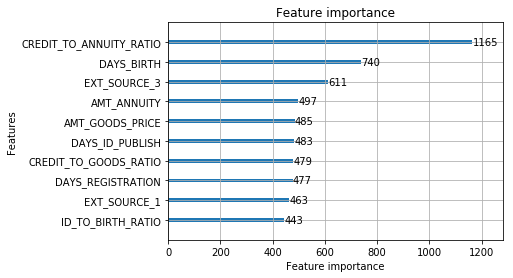

In [24]:
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=10, importance_type='split')